# DL

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
import keras
import utils
from keras.models import model_from_yaml
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
import numpy as np
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)

np.set_printoptions(threshold=50, edgeitems=20)

PATH='./data/'

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [92]:
def summary_df(df):
    display(DataFrameSummary(df).summary())

## Fast ai extension

In [3]:
class MyColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs)) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y), PassthruDataset(*(val_xs.T), val_y),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops, yhat_idx,
                    y_range=None, use_bn=False, **kwargs):
        model = MyMixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)

In [4]:
class MyMixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops, yhat_idx,
                 y_range=None, use_bn=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
#         szs = [n_emb+n_cont] + szs
        szs = [n_emb] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
#         self.yhat_idx = yhat_idx
        self.finalOp = nn.Linear(2, 1)
        

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
#             x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
#         x = torch.cat([x, x_cont], 1)
        x = self.outp(x)
        x3 = torch.cat([x, x_cont], 1)
        x = self.finalOp(x3)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x

## Create Data Set

In [14]:
visit_data_pp = pd.read_csv(f'{PATH}air_visit_data_with_prop_feas_2.csv')
weather_feas = pd.read_csv(f'{PATH}weather_data_merge.csv')
visit_data_pp.drop(columns=['Unnamed: 0'], inplace=True)

In [15]:
display(visit_data_pp.head())
display(visit_data_pp.columns)
display(DataFrameSummary(visit_data_pp).summary())

,air_store_id,visit_date,visitors,yhat,yhat_upper,yhat_lower,trend,trend_upper,trend_lower,holidays,...,holidays_lower,seasonal,seasonal_upper,seasonal_lower,seasonalities,seasonalities_upper,seasonalities_lower,weekly,weekly_upper,weekly_lower
0,air_ba937bf13d40fb24,13/1/2016,25,20.826006,37.535546,11.941791,14.452958,14.452958,14.452958,1.0,...,1.0,1.440951,1.440951,1.440951,1.440951,1.440951,1.440951,1.440951,1.440951,1.440951
1,air_ba937bf13d40fb24,14/1/2016,32,17.580470,29.262021,10.042691,14.478052,14.478052,14.478052,1.0,...,1.0,1.214284,1.214284,1.214284,1.214284,1.214284,1.214284,1.214284,1.214284,1.214284
2,air_ba937bf13d40fb24,15/1/2016,29,30.992940,54.328539,17.723215,14.503190,14.503190,14.503190,1.0,...,1.0,2.136974,2.136974,2.136974,2.136974,2.136974,2.136974,2.136974,2.136974,2.136974
3,air_ba937bf13d40fb24,16/1/2016,22,24.052839,42.666218,13.724146,14.528371,14.528371,14.528371,1.0,...,1.0,1.655577,1.655577,1.655577,1.655577,1.655577,1.655577,1.655577,1.655577,1.655577
4,air_ba937bf13d40fb24,18/1/2016,6,10.986390,19.049318,6.315840,14.578864,14.578864,14.578864,1.0,...,1.0,0.753583,0.753583,0.753583,0.753583,0.753583,0.753583,0.753583,0.753583,0.753583


Index(['air_store_id', 'visit_date', 'visitors', 'yhat', 'yhat_upper',
       'yhat_lower', 'trend', 'trend_upper', 'trend_lower', 'holidays',
       'holidays_upper', 'holidays_lower', 'seasonal', 'seasonal_upper',
       'seasonal_lower', 'seasonalities', 'seasonalities_upper',
       'seasonalities_lower', 'weekly', 'weekly_upper', 'weekly_lower'],
      dtype='object')

,air_store_id,visit_date,visitors,yhat,yhat_upper,yhat_lower,trend,trend_upper,trend_lower,holidays,...,holidays_lower,seasonal,seasonal_upper,seasonal_lower,seasonalities,seasonalities_upper,seasonalities_lower,weekly,weekly_upper,weekly_lower
count,NaN,NaN,252108,252108,252108,252108,252108,252108,252108,252108,...,252108,252108,252108,252108,252108,252108,252108,252108,252108,252108
mean,NaN,NaN,20.9738,18.872,36.2924,10.2297,16.7066,16.7066,16.7066,1.0164,...,1.0164,1.14264,1.14264,1.14264,1.12732,1.12732,1.12732,1.12732,1.12732,1.12732
std,NaN,NaN,16.757,12.8735,23.7684,8.18572,9.71724,9.71724,9.71724,0.156262,...,0.156262,0.439532,0.439532,0.439532,0.404204,0.404204,0.404204,0.404204,0.404204,0.404204
min,NaN,NaN,1,0.503156,1.0741,0.201433,0.816253,0.816253,0.816253,0.0286583,...,0.0286583,0.0257218,0.0257218,0.0257218,0.0460737,0.0460737,0.0460737,0.0460737,0.0460737,0.0460737
25%,NaN,NaN,9,9.03357,19.2976,4.14959,8.95559,8.95559,8.95559,1,...,1,0.863207,0.863207,0.863207,0.860852,0.860852,0.860852,0.860852,0.860852,0.860852
50%,NaN,NaN,17,15.8303,31.1566,7.85494,14.5345,14.5345,14.5345,1,...,1,1.05448,1.05448,1.05448,1.0439,1.0439,1.0439,1.0439,1.0439,1.0439
75%,NaN,NaN,29,25.5152,47.5329,14.1567,23.0372,23.0372,23.0372,1,...,1,1.34784,1.34784,1.34784,1.33346,1.33346,1.33346,1.33346,1.33346,1.33346
max,NaN,NaN,877,307.498,715.356,170.832,131.658,131.658,131.658,7.68166,...,7.68166,15.5166,15.5166,15.5166,8.00954,8.00954,8.00954,8.00954,8.00954,8.00954
counts,252108,252108,252108,252108,252108,252108,252108,252108,252108,252108,...,252108,252108,252108,252108,252108,252108,252108,252108,252108,252108
uniques,829,478,204,252101,252107,252105,252101,252101,252101,2502,...,2502,14356,14356,14356,5753,5753,5753,5753,5753,5753


In [16]:
display(weather_feas.head())
display(weather_feas.columns)
display(DataFrameSummary(weather_feas).summary())

,visit_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,...,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_latitude,station_longitude,station_vincenty,station_great_circle
0,2016-01-01,7.9,12.3,4.8,0.0,8.6,NaN,NaN,NaN,2.8,...,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",34.696667,135.211667,1.277232,1.274882
1,2016-01-01,7.9,12.3,4.8,0.0,8.6,NaN,NaN,NaN,2.8,...,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",34.696667,135.211667,1.277232,1.274882
2,2016-01-01,7.9,12.3,4.8,0.0,8.6,NaN,NaN,NaN,2.8,...,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",34.696667,135.211667,1.277232,1.274882
3,2016-01-01,7.9,12.3,4.8,0.0,8.6,NaN,NaN,NaN,2.8,...,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",34.696667,135.211667,1.277232,1.274882
4,2016-01-01,7.9,12.3,4.8,0.0,8.6,NaN,NaN,NaN,2.8,...,Dining bar,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",34.696667,135.211667,1.277232,1.274882


Index(['visit_date', 'avg_temperature', 'high_temperature', 'low_temperature',
       'precipitation', 'hours_sunlight', 'solar_radiation',
       'deepest_snowfall', 'total_snowfall', 'avg_wind_speed',
       'avg_vapor_pressure', 'avg_local_pressure', 'avg_humidity',
       'avg_sea_pressure', 'cloud_cover', 'station_id', 'air_store_id',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'latitude_str', 'longitude_str', 'station_latitude',
       'station_longitude', 'station_vincenty', 'station_great_circle'],
      dtype='object')

,visit_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,...,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_latitude,station_longitude,station_vincenty,station_great_circle
count,NaN,385165,385161,385161,294513,366948,287452,16418,9183,384972,...,NaN,NaN,428593,428593,NaN,NaN,428593,428593,428593,428593
mean,NaN,14.6977,19.144,10.8993,5.91825,5.52442,13.5146,33.2732,4.7197,2.85767,...,NaN,NaN,35.647,137.415,NaN,NaN,35.6484,137.415,3.83125,3.83143
std,NaN,8.2191,8.46122,8.50146,14.052,4.10359,7.41456,29.4018,6.00985,1.14048,...,NaN,NaN,2.0834,3.64877,NaN,NaN,2.08328,3.64843,2.21526,2.21517
min,NaN,-18.8,-10.6,-29.1,0,0,0.48,0,0,0.3,...,NaN,NaN,33.212,130.196,NaN,NaN,33.225,130.19,0.416011,0.415906
25%,NaN,7.8,12.3,3.7,0,1.3,7.55,2,1,2.1,...,NaN,NaN,34.6951,135.342,NaN,NaN,34.6817,135.335,1.939,1.93624
50%,NaN,14.5,19.2,10.2,0,5.7,12.26,32,3,2.7,...,NaN,NaN,35.6581,139.685,NaN,NaN,35.6917,139.62,3.57524,3.57845
75%,NaN,21.6,26.1,18,5,9,19.13,58,6,3.4,...,NaN,NaN,35.694,139.752,NaN,NaN,35.6917,139.75,5.31996,5.31864
max,NaN,32.4,38.3,28.9,208,14.8,31.32,96,69,12.8,...,NaN,NaN,44.0206,144.273,NaN,NaN,44.0167,144.278,12.2173,12.19
counts,428593,385165,385161,385161,294513,366948,287452,16418,9183,384972,...,428593,428593,428593,428593,428593,428593,428593,428593,428593,428593
uniques,517,452,463,505,214,147,2402,94,35,110,...,14,103,108,108,108,108,38,38,108,108


In [17]:
test_raw = pd.read_csv(f'{PATH}sample_submission.csv')
test_data = utils.tes2trn(test_raw)
test_stores = test_data.air_store_id.unique()
len(test_stores)

821

remove stores which are not in test set

In [18]:
def add_area_stat(df, prefix):
    area_col_name = prefix + '_area_name'
    genre_col_name = prefix + '_genre_name'
    
    def count_stores_in_area(area_df):
        store_cnt = len(area_df.air_store_id.unique())
        area_df[f'stores_in_{prefix}_area'] = store_cnt
        return area_df
    
    def count_genres_in_area(area_df):
        genre_cnt = len(area_df[genre_col_name].unique())
        area_df[f'genres_in_{prefix}_area'] = genre_cnt
        return area_df
        
    df = df.groupby(area_col_name).apply(count_stores_in_area)
    df = df.groupby(area_col_name).apply(count_genres_in_area)
    return df

In [19]:
joined_raw = visit_data_pp[visit_data_pp.air_store_id.isin(test_stores)]
air_store_info = pd.read_csv('{}air_store_info.csv'.format(PATH))
joined_raw = pd.merge(joined_raw, air_store_info, how='left', left_on='air_store_id', right_on='air_store_id')

In [20]:
joined = add_area_stat(joined_raw, 'air')
joined['visit_date'] = pd.to_datetime(joined.visit_date)
weather_feas['visit_date'] = pd.to_datetime(weather_feas.visit_date)

In [21]:
weather = weather_feas[['visit_date', 'avg_temperature', 'high_temperature', 'low_temperature',
       'precipitation', 'hours_sunlight', 'solar_radiation',
       'deepest_snowfall', 'total_snowfall', 'avg_wind_speed',
       'avg_vapor_pressure', 'avg_local_pressure', 'avg_humidity',
       'avg_sea_pressure', 'cloud_cover', 'station_id', 'air_store_id']]

In [25]:
joined = pd.merge(joined, weather, how='left', left_on=['air_store_id', 'visit_date'], right_on=['air_store_id', 'visit_date'])

In [26]:
joined.head().T.head(100)

,0,1,2,3,4
air_store_id,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24
visit_date,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-16 00:00:00,2016-01-18 00:00:00
visitors,25,32,29,22,6
yhat,20.826,17.5805,30.9929,24.0528,10.9864
yhat_upper,37.5355,29.262,54.3285,42.6662,19.0493
yhat_lower,11.9418,10.0427,17.7232,13.7241,6.31584
trend,14.453,14.4781,14.5032,14.5284,14.5789
trend_upper,14.453,14.4781,14.5032,14.5284,14.5789
trend_lower,14.453,14.4781,14.5032,14.5284,14.5789
holidays,1,1,1,1,1


In [25]:
def dropMissingCols(df):
    summary = DataFrameSummary(weather_feas).summary()
    dropped_cols = []
    for col in summary:
        if(float(summary.loc['missing_perc', col][:-1]) >50):
            dropped_cols.append(col)
    return dropped_cols

In [28]:
dp_cols = dropMissingCols(joined)

In [29]:
joined = joined.drop(columns=dp_cols)

In [30]:
joined.columns

Index(['air_store_id', 'visit_date', 'visitors', 'yhat', 'yhat_upper',
       'yhat_lower', 'trend', 'trend_upper', 'trend_lower', 'holidays',
       'holidays_upper', 'holidays_lower', 'seasonal', 'seasonal_upper',
       'seasonal_lower', 'seasonalities', 'seasonalities_upper',
       'seasonalities_lower', 'weekly', 'weekly_upper', 'weekly_lower',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'stores_in_air_area', 'genres_in_air_area', 'avg_temperature',
       'high_temperature', 'low_temperature', 'precipitation',
       'hours_sunlight', 'solar_radiation', 'avg_wind_speed',
       'avg_vapor_pressure', 'avg_local_pressure', 'avg_humidity',
       'avg_sea_pressure', 'cloud_cover', 'station_id'],
      dtype='object')

In [ ]:
# joined = joined.drop(columns=['trend_upper', 'trend_lower', ])

In [22]:
store_feas = joined.groupby('air_store_id').mean()
store_feas = store_feas.reset_index()[['air_store_id', 'stores_in_air_area', 'genres_in_air_area']]
store_feas.head()

,air_store_id,stores_in_air_area,genres_in_air_area
0,air_00a91d42b08b08d9,20.0,7.0
1,air_0164b9927d20bcc3,51.0,7.0
2,air_0241aa3964b7f861,15.0,4.0
3,air_0328696196e46f18,2.0,1.0
4,air_034a3d5b40d5b1b1,4.0,2.0


In [23]:
# joined_test = pd.merge(test_data, air_store_info, how='left', left_on='air_store_id', right_on='air_store_id')
joined_test = pd.merge(test_data, store_feas, how='left', left_on='air_store_id', right_on='air_store_id')
joined_test['visit_date'] = pd.to_datetime(joined_test.visit_date)
joined_test = pd.merge(joined_test, weather, how='left', left_on=['air_store_id', 'visit_date'], right_on=['air_store_id', 'visit_date'])

In [26]:
test_dp_cols = dropMissingCols(joined_test)

In [27]:
joined_test = joined_test.drop(columns=test_dp_cols)

In [28]:
pkl_file = open(f'{PATH}ts_prep.pkl', 'rb')
ts_pp = pickle.load(pkl_file)
pkl_file.close()

In [29]:
for model_key in ts_pp.keys():
        ts_pp[model_key] = ts_pp[model_key].assign(air_store_id=model_key)
        ts_pp[model_key] = ts_pp[model_key].rename({
            'ds': 'visit_date',
        }, axis="columns")

In [30]:
concated = pd.concat([res for res in ts_pp.values()], axis=0)

In [31]:
summary_df(concated)

,visit_date,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,1,1_lower,1_upper,2,...,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat,air_store_id
count,NaN,429422,429422,429422,429422,429422,429422,429422,429422,429422,...,429422,429422,429422,429422,429422,429422,429422,429422,429422,NaN
mean,NaN,2.56976,2.56958,2.56994,1.88215,3.26542,0.00299514,0.00299514,0.00299514,0.000313272,...,0.00402345,0.00402345,-3.64313e-16,-3.64313e-16,-3.64313e-16,-3.64313e-16,-3.64313e-16,-3.64313e-16,2.57378,NaN
std,NaN,0.947122,0.947166,0.9471,1.12123,1.01783,0.0933449,0.0933449,0.0933449,0.0204419,...,0.453009,0.453009,0.434971,0.434971,0.434971,0.434971,0.434971,0.434971,1.0496,NaN
min,NaN,-26.3935,-26.3935,-26.3935,-26.7764,-26.1882,-3.55231,-3.55231,-3.55231,-3.51143,...,-6.23856,-6.23856,-3.07751,-3.07751,-3.07751,-3.07751,-3.07751,-3.07751,-26.4835,NaN
25%,NaN,2.13853,2.13849,2.13858,1.27939,2.83844,0,0,0,0,...,-0.188449,-0.188449,-0.187914,-0.187914,-0.187914,-0.187914,-0.187914,-0.187914,2.07561,NaN
50%,NaN,2.6349,2.63483,2.63491,1.96648,3.36277,0,0,0,0,...,0.0166196,0.0166196,0.0101448,0.0101448,0.0101448,0.0101448,0.0101448,0.0101448,2.67283,NaN
75%,NaN,3.12017,3.12013,3.12021,2.59723,3.82415,0,0,0,0,...,0.270831,0.270831,0.259287,0.259287,0.259287,0.259287,0.259287,0.259287,3.19681,NaN
max,NaN,6.52445,6.31497,6.7498,6.38696,7.993,1.68112,1.68112,1.68112,2.03884,...,2.74191,2.74191,2.08063,2.08063,2.08063,2.08063,2.08063,2.08063,6.76631,NaN
counts,429422,429422,429422,429422,429422,429422,429422,429422,429422,429422,...,429422,429422,429422,429422,429422,429422,429422,429422,429422,429422
uniques,518,429422,429422,429422,429422,429422,804,804,804,256,...,428718,428718,428625,428625,428625,428625,428625,428625,429422,829


In [38]:
concated['visit_date'] = pd.to_datetime(concated.visit_date)

In [41]:
concated = concated.drop(columns=['1', '1_lower', '1_upper', '2', '2_lower', '2_upper', '3',
       '3_lower', '3_upper', '6', '6_lower', '6_upper'])
concated.columns

Index(['visit_date', 'trend', 'trend_lower', 'trend_upper', 'yhat_lower',
       'yhat_upper', 'holidays', 'holidays_lower', 'holidays_upper',
       'seasonal', 'seasonal_lower', 'seasonal_upper', 'seasonalities',
       'seasonalities_lower', 'seasonalities_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yhat', 'air_store_id'],
      dtype='object')

In [42]:
jd_test = pd.merge(joined_test, concated, how='left',
                  left_on=['visit_date', 'air_store_id'],
                  right_on=['visit_date', 'air_store_id'])

In [49]:
air_store_info = pd.read_csv('./data/air_store_info.csv')
jd_test = pd.merge(jd_test, air_store_info, how='left', left_on='air_store_id', right_on='air_store_id')

In [50]:
jd_test.to_csv('./data/joined_test_full.csv', index=False)

In [23]:
def tes2trn(tes):
    tes = tes.assign(
        air_store_id=tes["id"].map(lambda x: '_'.join(x.split('_')[:-1])))
    tes = tes.assign(visit_date=tes["id"].map(lambda x: x.split('_')[2]))
    return tes[["air_store_id", "visit_date", "visitors"]]

In [24]:
test_pp = pd.read_csv('./result/pp_submission_501.csv')
test_pp.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.713417
1,air_00a91d42b08b08d9_2017-04-24,22.902539
2,air_00a91d42b08b08d9_2017-04-25,24.945218
3,air_00a91d42b08b08d9_2017-04-26,30.442141
4,air_00a91d42b08b08d9_2017-04-27,32.736847


In [25]:
test_pp =tes2trn(test_pp)

In [26]:
test_pp.head()

,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2017-04-23,2.713417
1,air_00a91d42b08b08d9,2017-04-24,22.902539
2,air_00a91d42b08b08d9,2017-04-25,24.945218
3,air_00a91d42b08b08d9,2017-04-26,30.442141
4,air_00a91d42b08b08d9,2017-04-27,32.736847


In [27]:
test_pp = test_pp.rename({'visitors': 'yhat'}, axis='columns')

In [28]:
test_pp['visit_date'] = pd.to_datetime(test_pp.visit_date)
joined_test = pd.merge(joined_test, test_pp, how='left',
                        left_on=['air_store_id', 'visit_date'], right_on=['air_store_id', 'visit_date'])

In [31]:
# joined.to_csv('./data/joined_full.csv', index=False)
# joined_test.to_csv('./data/joined_test.csv', index=False)

In [46]:
joined = pd.read_csv(f'{PATH}joined.csv')
joined_test = pd.read_csv(f'{PATH}joined_test.csv')

In [47]:
joined['visit_date'] = pd.to_datetime(joined.visit_date)
joined_test['visit_date'] = pd.to_datetime(joined_test.visit_date)

In [50]:
joined = addTimeFeas(joined)
joined_test = addTimeFeas(joined_test)

In [61]:
joined.to_csv(f'{PATH}joined_emb.csv', index=False)
joined_test.to_csv(f'{PATH}joined_test_emb.csv', index=False)


In [49]:
def addTimeFeas(df):
    df = df.copy()
    df['dow'] = df.visit_date.dt.dayofweek
    df['day'] = df.visit_date.dt.day
    df['month'] = df.visit_date.dt.month
    df['year'] = df.visit_date.dt.year
    df['week'] = df.visit_date.dt.week
    return df

## Merge PP Features

In [85]:
# joined = pd.read_csv(f'{PATH}joined.csv')
joined = pd.read_csv(f'{PATH}joined_emb.csv')
joined_test = pd.read_csv(f'{PATH}joined_test_emb.csv')
pkl_file = open(f'{PATH}ts_prep.pkl', 'rb')
ts_pp = pickle.load(pkl_file)
pkl_file.close()

In [87]:
joined = joined.drop(columns='yhat')

In [106]:
joined_pp = add_prop(joined, ts_pp)

In [116]:
joined_pp_test = add_prop(joined_test.drop(columns='yhat'), ts_pp)

In [113]:
joined2 = pd.read_csv(f'{PATH}joined_full_time.csv')
summary_df(joined2)

,air_store_id,visit_date,visitors,yhat,yhat_upper,yhat_lower,trend,trend_upper,trend_lower,holidays,...,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,station_id,dow,day,month,year,week
count,NaN,NaN,250468,250468,250468,250468,250468,250468,250468,250468,...,171151,170941,171151,162631,NaN,250468,250468,250468,250468,250468
mean,NaN,NaN,20.9593,18.8662,36.26,10.2288,16.7019,16.7019,16.7019,1.01644,...,1011.01,67.3743,1015.09,6.91308,NaN,3.00625,15.4559,6.3419,2016.31,25.6318
std,NaN,NaN,16.7398,12.8887,23.8119,8.1838,9.72922,9.72922,9.72922,0.156314,...,7.77574,14.8385,7.28097,3.06018,NaN,1.95762,8.84403,3.60875,0.461903,15.6714
min,NaN,NaN,1,0.503156,1.0741,0.201433,0.816253,0.816253,0.816253,0.0286583,...,975.7,24,985.8,0,NaN,0,1,1,2016,1
25%,NaN,NaN,9,9.00904,19.2328,4.14162,8.92564,8.92564,8.92564,1,...,1006,56,1010.3,4.8,NaN,1,8,3,2016,11
50%,NaN,NaN,17,15.8131,31.0728,7.85964,14.5205,14.5205,14.5205,1,...,1011.5,67,1015.6,7.5,NaN,3,16,7,2016,27
75%,NaN,NaN,29,25.5454,47.5009,14.1651,23.0677,23.0677,23.0677,1,...,1016.2,78,1020,10,NaN,5,23,10,2017,40
max,NaN,NaN,877,307.498,715.356,170.832,131.658,131.658,131.658,7.68166,...,1031.6,100,1036.2,10,NaN,6,31,12,2017,53
counts,250468,250468,250468,250468,250468,250468,250468,250468,250468,250468,...,171151,170941,171151,162631,230997,250468,250468,250468,250468,250468
uniques,821,478,203,250461,250467,250465,250461,250461,250461,2483,...,459,74,385,51,38,7,31,12,2,53


(array([ 76829.,  81805.,  48836.,  25724.,  11133.,   4147.,   1155.,    440.,    164.,     72.]),
 array([  0.50316,  10.42693,  20.3507 ,  30.27447,  40.19824,  50.12202,  60.04579,  69.96956,  79.89333,
         89.81711,  99.74088]),
 <a list of 10 Patch objects>)

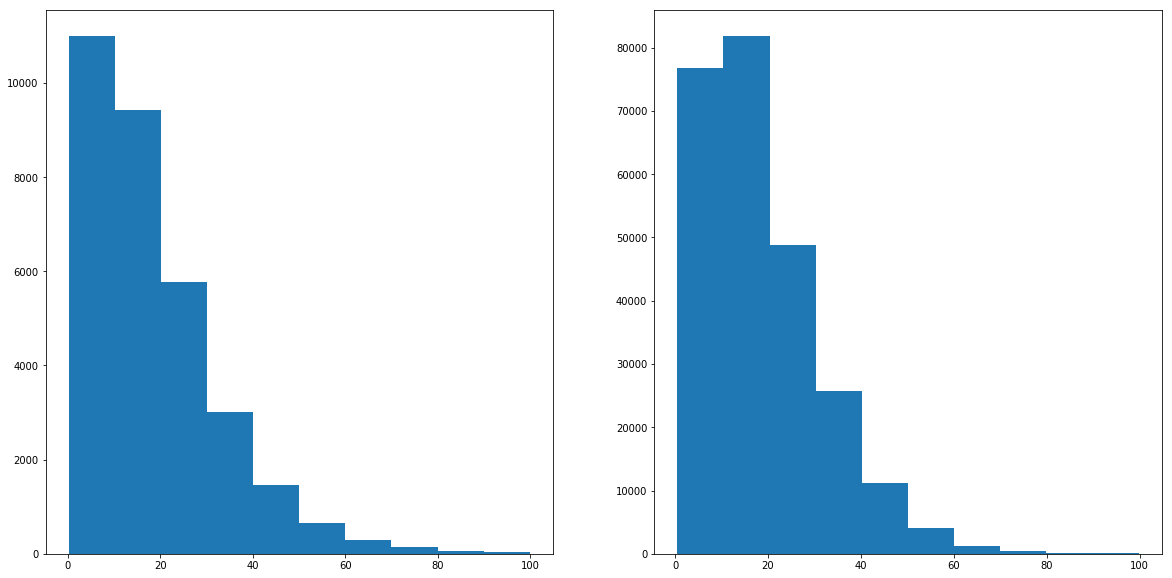

In [161]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(joined_pp_test[joined_pp_test.yhat<100].yhat)
plt.subplot(1, 2, 2)
plt.hist(joined2[joined2.yhat<100].yhat)

In [117]:
summary_df(joined_pp_test)

,air_store_id,visit_date,stores_in_air_area,genres_in_air_area,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
count,NaN,NaN,32019,32019,28743,28743,28743,19289,27378,21450,...,32019,32019,32019,32019,32019,32019,32019,32019,32019,32019
mean,NaN,NaN,23.7308,5.15225,18.9276,23.9827,14.6282,3.1138,7.5585,20.3003,...,1.09176,1.09176,1.09176,1.07378,1.07378,1.07378,1.07378,1.07378,1.07378,19.4458
std,NaN,NaN,20.0156,3.10636,3.16006,3.71012,3.45211,8.02538,4.59663,7.60923,...,0.509191,0.509191,0.509191,0.429703,0.429703,0.429703,0.429703,0.429703,0.429703,21.2917
min,NaN,NaN,1,1,-0.2,0.9,-2,0,0,1.3,...,0.0156298,0.0156298,0.0156298,0.0460737,0.0460737,0.0460737,0.0460737,0.0460737,0.0460737,0.214132
25%,NaN,NaN,7,2,17.1,21.4,12.3,0,3.7,15.52,...,0.814768,0.814768,0.814768,0.820978,0.820978,0.820978,0.820978,0.820978,0.820978,7.78157
50%,NaN,NaN,19,5,19.1,24.1,15.1,0,8.7,22.9,...,0.998828,0.998828,0.998828,0.998724,0.998724,0.998724,0.998724,0.998724,0.998724,14.9281
75%,NaN,NaN,39,7,21.2,26.9,17.2,1.5,12.1,26.86,...,1.29255,1.29255,1.29255,1.27977,1.27977,1.27977,1.27977,1.27977,1.27977,25.8965
max,NaN,NaN,63,12,25.1,33,21.7,72.5,14.1,30.25,...,14.2149,14.2149,14.2149,8.00954,8.00954,8.00954,8.00954,8.00954,8.00954,868.101
counts,32019,32019,32019,32019,28743,28743,28743,19289,27378,21450,...,32019,32019,32019,32019,32019,32019,32019,32019,32019,32019
uniques,821,39,28,9,176,199,194,75,141,391,...,32009,32009,32009,32009,32009,32009,32009,32009,32009,32019


In [118]:
summary_df(joined_pp_test)

,air_store_id,visit_date,stores_in_air_area,genres_in_air_area,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
count,NaN,NaN,32019,32019,28743,28743,28743,19289,27378,21450,...,32019,32019,32019,32019,32019,32019,32019,32019,32019,32019
mean,NaN,NaN,23.7308,5.15225,18.9276,23.9827,14.6282,3.1138,7.5585,20.3003,...,1.09176,1.09176,1.09176,1.07378,1.07378,1.07378,1.07378,1.07378,1.07378,19.4458
std,NaN,NaN,20.0156,3.10636,3.16006,3.71012,3.45211,8.02538,4.59663,7.60923,...,0.509191,0.509191,0.509191,0.429703,0.429703,0.429703,0.429703,0.429703,0.429703,21.2917
min,NaN,NaN,1,1,-0.2,0.9,-2,0,0,1.3,...,0.0156298,0.0156298,0.0156298,0.0460737,0.0460737,0.0460737,0.0460737,0.0460737,0.0460737,0.214132
25%,NaN,NaN,7,2,17.1,21.4,12.3,0,3.7,15.52,...,0.814768,0.814768,0.814768,0.820978,0.820978,0.820978,0.820978,0.820978,0.820978,7.78157
50%,NaN,NaN,19,5,19.1,24.1,15.1,0,8.7,22.9,...,0.998828,0.998828,0.998828,0.998724,0.998724,0.998724,0.998724,0.998724,0.998724,14.9281
75%,NaN,NaN,39,7,21.2,26.9,17.2,1.5,12.1,26.86,...,1.29255,1.29255,1.29255,1.27977,1.27977,1.27977,1.27977,1.27977,1.27977,25.8965
max,NaN,NaN,63,12,25.1,33,21.7,72.5,14.1,30.25,...,14.2149,14.2149,14.2149,8.00954,8.00954,8.00954,8.00954,8.00954,8.00954,868.101
counts,32019,32019,32019,32019,28743,28743,28743,19289,27378,21450,...,32019,32019,32019,32019,32019,32019,32019,32019,32019,32019
uniques,821,39,28,9,176,199,194,75,141,391,...,32009,32009,32009,32009,32009,32009,32009,32009,32009,32019


In [124]:
joined_pp_test.to_csv(f'{PATH}joined_test_full_time.csv', index=False)

In [115]:
def add_prop(trn, ts_feat):
    ' add prophet features to train like dataframe'
    for model_key in ts_feat.keys():
        ts_feat[model_key] = ts_feat[model_key].assign(air_store_id=model_key)
        ts_feat[model_key] = ts_feat[model_key].rename({
            'ds': 'visit_date',
        }, axis="columns")
    concated = pd.concat([res for res in ts_feat.values()], axis=0)
    concated.yhat = np.exp(concated.yhat.values)
    concated.yhat_upper = np.exp(concated.yhat_upper.values)
    concated.yhat_lower = np.exp(concated.yhat_lower.values)
    cols = ['trend', 'trend_upper', 'trend_lower', 'holidays',
       'holidays_upper', 'holidays_lower', 'seasonal', 'seasonal_upper',
       'seasonal_lower', 'seasonalities', 'seasonalities_upper',
       'seasonalities_lower', 'weekly', 'weekly_upper', 'weekly_lower']
    for col in cols:
        concated[col] = np.exp(concated[col].values)
    concated.visit_date = concated.visit_date.astype('str')
    name_dict = {col: '{}'.format(
        col) for col in concated.columns if col != 'visit_date' and col != 'air_store_id'}
    concated.rename(columns=dict(name_dict), inplace=True)
    trn.visit_date = trn.visit_date.astype('str')
    en_trn = pd.merge(trn, concated, on=['visit_date', 'air_store_id'], how='left')
    return en_trn

## Create Features

In [3]:
# joined = pd.read_csv(f'{PATH}joined.csv')
joined = pd.read_csv(f'{PATH}joined_full_time.csv')
joined_test = pd.read_csv(f'{PATH}joined_test_full_time.csv')

In [126]:
joined.columns

Index(['air_store_id', 'visit_date', 'visitors', 'yhat', 'yhat_upper',
       'yhat_lower', 'trend', 'trend_upper', 'trend_lower', 'holidays',
       'holidays_upper', 'holidays_lower', 'seasonal', 'seasonal_upper',
       'seasonal_lower', 'seasonalities', 'seasonalities_upper',
       'seasonalities_lower', 'weekly', 'weekly_upper', 'weekly_lower',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'stores_in_air_area', 'genres_in_air_area', 'avg_temperature',
       'high_temperature', 'low_temperature', 'precipitation',
       'hours_sunlight', 'solar_radiation', 'avg_wind_speed',
       'avg_vapor_pressure', 'avg_local_pressure', 'avg_humidity',
       'avg_sea_pressure', 'cloud_cover', 'station_id', 'dow', 'day', 'month',
       'year', 'week'],
      dtype='object')

In [127]:
joined_test.columns

Index(['air_store_id', 'visit_date', 'stores_in_air_area',
       'genres_in_air_area', 'avg_temperature', 'high_temperature',
       'low_temperature', 'precipitation', 'hours_sunlight', 'solar_radiation',
       'avg_wind_speed', 'avg_vapor_pressure', 'avg_local_pressure',
       'avg_humidity', 'avg_sea_pressure', 'cloud_cover', 'station_id',
       'visitors', 'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'dow', 'day', 'month', 'year', 'week', 'trend', 'trend_lower',
       'trend_upper', 'yhat_lower', 'yhat_upper', '1', '1_lower', '1_upper',
       '2', '2_lower', '2_upper', '3', '3_lower', '3_upper', '6', '6_lower',
       '6_upper', 'holidays', 'holidays_lower', 'holidays_upper', 'seasonal',
       'seasonal_lower', 'seasonal_upper', 'seasonalities',
       'seasonalities_lower', 'seasonalities_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yhat'],
      dtype='object')

In [4]:
cat_vars = ['air_store_id','air_genre_name', 'air_area_name', 'dow', 'day', 'month',
       'year', 'week']

# contin_vars = ['yhat','stores_in_air_area', 'genres_in_air_area',
#        'avg_temperature', 'high_temperature', 'low_temperature',
#        'precipitation', 'hours_sunlight', 'solar_radiation', 'avg_wind_speed',
#        'avg_vapor_pressure', 'avg_local_pressure', 'avg_humidity',
#        'avg_sea_pressure', 'cloud_cover' ]
contin_vars = [ 
        'yhat',
    'trend', 'holidays', 'seasonal', 'seasonalities',  'weekly',
#         'trend', 'trend_upper', 'trend_lower', 'holidays',
#        'holidays_upper', 'holidays_lower', 'seasonal', 'seasonal_upper',
#        'seasonal_lower', 'seasonalities', 'seasonalities_upper',
#        'seasonalities_lower', 'weekly', 'weekly_upper', 'weekly_lower',
       'stores_in_air_area', 'genres_in_air_area',
       'avg_temperature', 'high_temperature', 'low_temperature',
       'precipitation', 'hours_sunlight', 'solar_radiation', 'avg_wind_speed',
       'avg_vapor_pressure', 'avg_local_pressure', 'avg_humidity',
       'avg_sea_pressure', 'cloud_cover' 
]
all_vars = cat_vars + contin_vars

dep = 'visitors'
joined = joined[all_vars+[dep, 'visit_date']]

joined_test[dep] = 0
joined_test = joined_test[all_vars+[dep, 'visit_date']]

joined_test['visit_date'] = pd.to_datetime(joined_test.visit_date)
joined['visit_date'] = pd.to_datetime(joined.visit_date)

for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

apply_cats(joined_test, joined)

for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

joined = joined.set_index("visit_date")
df, y, nas, mapper = proc_df(joined, 'visitors', do_scale=True)
yl = np.log(y)

joined_test = joined_test.set_index("visit_date")
df_test, _, nas, mapper = proc_df(joined_test, 'visitors', do_scale=True, mapper=mapper, na_dict=nas)

val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2017,4,23)) & (df.index>=datetime.datetime(2017,3,14)))

In [122]:
cat_cols = [c.values for n,c in df[cat_vars].items()]

In [111]:
a  = np.stack(cat_cols, 1)
b = np.stack(cat_cols)

array([600,   5,  63,   3,  13,   1,   1,   2], dtype=int16)

In [8]:
summary_df(df)

,air_store_id,air_genre_name,air_area_name,dow,day,month,year,week,yhat,stores_in_air_area,...,low_temperature_na,precipitation_na,hours_sunlight_na,solar_radiation_na,avg_wind_speed_na,avg_vapor_pressure_na,avg_local_pressure_na,avg_humidity_na,avg_sea_pressure_na,cloud_cover_na
count,250468,250468,250468,250468,250468,250468,250468,250468,250468,250468,...,250468,250468,250468,250468,250468,250468,250468,250468,250468,250468
mean,409.415,6.27882,51.1275,4.00625,15.4559,6.3419,1.30857,25.6318,9.03564e-08,6.00843e-09,...,-1.14836e-16,1.23347e-16,-1.51829e-16,7.69357e-17,-5.99145e-17,-4.6638e-17,-4.28933e-17,-4.6638e-17,-4.28933e-17,-1.81559e-17
std,237.683,3.12509,30.6284,1.95762,8.84403,3.60875,0.461903,15.6714,1,1,...,1,1,1,1,1,1,1,1,1,1
min,1,1,1,1,1,1,1,1,-1.42474,-1.12676,...,-0.449727,-0.759858,-0.512363,-0.784834,-0.450355,-0.682078,-0.680759,-0.682078,-0.680759,-0.734915
25%,203,3,26,2,8,3,1,11,-0.764788,-0.877244,...,-0.449727,-0.759858,-0.512363,-0.784834,-0.450355,-0.682078,-0.680759,-0.682078,-0.680759,-0.734915
50%,402,7,56,4,16,7,1,27,-0.236875,-0.2285,...,-0.449727,-0.759858,-0.512363,-0.784834,-0.450355,-0.682078,-0.680759,-0.682078,-0.680759,-0.734915
75%,619,8,76,6,23,10,2,40,0.518224,0.769568,...,-0.449727,1.31604,-0.512363,1.27415,-0.450355,1.46611,1.46895,1.46611,1.46895,1.3607
max,821,14,103,7,31,12,2,53,22.3942,1.96725,...,2.22357,1.31604,1.95174,1.27415,2.22047,1.46611,1.46895,1.46611,1.46895,1.3607
counts,250468,250468,250468,250468,250468,250468,250468,250468,250468,250468,...,250468,250468,250468,250468,250468,250468,250468,250468,250468,250468
uniques,821,14,103,7,31,12,2,53,249257,28,...,2,2,2,2,2,2,2,2,2,2


In [9]:
summary_df(df_test)

,air_store_id,air_genre_name,air_area_name,dow,day,month,year,week,yhat,stores_in_air_area,...,low_temperature_na,precipitation_na,hours_sunlight_na,solar_radiation_na,avg_wind_speed_na,avg_vapor_pressure_na,avg_local_pressure_na,avg_humidity_na,avg_sea_pressure_na,cloud_cover_na
count,32019,32019,32019,32019,32019,32019,32019,32019,32019,32019,...,32019,32019,32019,32019,32019,32019,32019,32019,32019,32019
mean,411,6.27527,51.2241,3.92308,18.1538,4.79487,2,19.1538,0.0520664,0.00758391,...,-0.17621,0.0654688,-0.155203,-0.105192,-0.176925,-0.117709,-0.117803,-0.117709,-0.117803,-0.106996
std,237.006,3.13365,30.4455,2.04296,9.09096,0.403802,0,1.64145,1.51347,0.998845,...,0.810186,1.01595,0.86749,0.968241,0.809655,0.945455,0.945145,0.945455,0.945145,0.960013
min,1,1,1,1,1,4,2,16,-1.49047,-1.12676,...,-0.449727,-0.759858,-0.512363,-0.784834,-0.450355,-0.682078,-0.680759,-0.682078,-0.680759,-0.734915
25%,206,3,26,2,10,5,2,18,-0.83911,-0.827341,...,-0.449727,-0.759858,-0.512363,-0.784834,-0.450355,-0.682078,-0.680759,-0.682078,-0.680759,-0.734915
50%,411,7,56,4,20,5,2,19,-0.285438,-0.2285,...,-0.449727,-0.759858,-0.512363,-0.784834,-0.450355,-0.682078,-0.680759,-0.682078,-0.680759,-0.734915
75%,616,8,75,6,26,5,2,21,0.554859,0.769568,...,-0.449727,1.31604,-0.512363,1.27415,-0.450355,1.46611,1.46895,1.46611,1.46895,1.3607
max,821,14,103,7,31,5,2,22,48.6805,1.96725,...,2.22357,1.31604,1.95174,1.27415,2.22047,1.46611,1.46895,1.46611,1.46895,1.3607
counts,32019,32019,32019,32019,32019,32019,32019,32019,32019,32019,...,32019,32019,32019,32019,32019,32019,32019,32019,32019,32019
uniques,821,14,103,7,31,2,1,7,32000,28,...,2,2,2,2,2,2,2,2,2,2


## DL

In [14]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = np.log1p(targ) - np.log1p(inv_y(y_pred))
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [15]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=32,
                                       test_df=df_test)

In [16]:
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]

In [17]:
cat_sz

[('air_store_id', 822),
 ('air_genre_name', 15),
 ('air_area_name', 104),
 ('dow', 8),
 ('day', 32),
 ('month', 13),
 ('year', 3),
 ('week', 54)]

In [18]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [19]:
emb_szs

[(822, 50), (15, 8), (104, 50), (8, 4), (32, 16), (13, 7), (3, 2), (54, 27)]

In [20]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [128, 64, 32], [0.01, 0.01, 0.01], y_range=y_range, use_bn=True)
lr = 1e-3

In [46]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 62%|██████▏   | 4408/7111 [00:50<00:30, 88.14it/s, loss=1.27]  

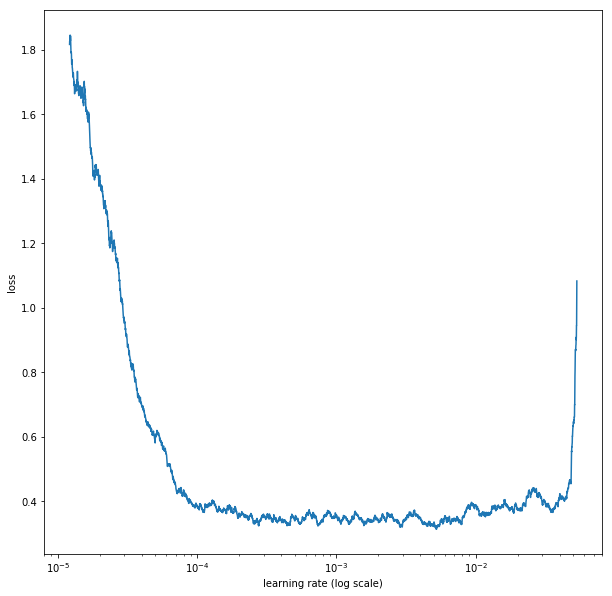

In [47]:
rcParams['figure.figsize'] = 10, 10
m.sched.plot(100)

In [21]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [128, 64, 32], [0.1, 0.1, 0.1], y_range=y_range, use_bn=True)
lr = 1e-4

In [22]:
#dl_fullfea_u30
m.fit(1e-3, 1, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.31431  0.30978  0.47517]                           



In [55]:
m.fit(1e-4, 1, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.30776  0.30085  0.46934]                           



In [23]:
preds = m.predict()

In [28]:
preds

array([[ 2.94488],
       [ 2.99429],
       [ 2.66934],
       [ 2.90561],
       [ 2.75803],
       [ 3.29618],
       [ 3.06529],
       [ 1.07141],
       [ 2.63833],
       [ 2.95546],
       [ 2.75954],
       [ 3.31846],
       [ 3.135  ],
       [ 2.33202],
       [ 2.82679],
       [ 2.95435],
       [ 2.72091],
       [ 3.12085],
       [ 2.45743],
       [ 2.57431],
       ..., 
       [ 1.81906],
       [ 1.85269],
       [ 2.09653],
       [ 1.83361],
       [ 1.87604],
       [ 1.75887],
       [ 1.72855],
       [ 2.09852],
       [ 2.12993],
       [ 1.91731],
       [ 1.8218 ],
       [ 1.7796 ],
       [ 1.71664],
       [ 1.82812],
       [ 1.67304],
       [ 1.73174],
       [ 2.02191],
       [ 1.8248 ],
       [ 1.87086],
       [ 1.65695]], dtype=float32)

In [27]:
yl[val_idx]

array([ 3.4012 ,  3.73767,  1.94591,  3.04452,  2.48491,  3.55535,  1.94591,  0.     ,  2.19722,  3.29584,
        2.77259,  3.29584,  2.99573,  1.79176,  2.89037,  2.99573,  2.99573,  3.43399,  3.46574,  2.83321,
       ...,  1.94591,  0.69315,  2.07944,  2.07944,  1.94591,  0.69315,  1.38629,  1.94591,  2.3979 ,
        1.94591,  2.07944,  0.69315,  1.79176,  0.69315,  1.94591,  1.79176,  1.79176,  1.94591,  2.07944,
        1.60944])

In [26]:
m.save('test')

In [29]:
exp_rmspe(preds, yl[val_idx])

1.0521477600514804

In [67]:
m.fit(1e-4, 1, metrics=[exp_rmspe], cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.27138  0.30157  0.46936]                           
[ 1.       0.31431  0.30129  0.46964]                           



In [68]:
#dl_fullfea_u50 [0.15, 0.1]
m.fit(1e-4, 3, metrics=[exp_rmspe], cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.29539  0.30093  0.46955]                           
[ 1.       0.30364  0.30199  0.47033]                           
[ 2.       0.31983  0.30181  0.47013]                           
[ 3.       0.29772  0.30186  0.4706 ]                           
[ 4.       0.29037  0.30179  0.47003]                           
[ 5.       0.31181  0.30247  0.47078]                           
[ 6.       0.291    0.30269  0.47076]                           



In [18]:
#dl_fullfea_u30 [0.1, 0.1]
m.fit(1e-4, 3, metrics=[exp_rmspe], cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.33008  0.30715  0.47437]                           
[ 1.       0.29721  0.3073   0.47478]                           
[ 2.       0.30863  0.30651  0.47401]                           
[ 3.       0.32037  0.3085   0.47537]                           
[ 4.       0.28899  0.30767  0.47481]                           
[ 5.       0.31296  0.30762  0.47512]                           
[ 6.       0.28284  0.3077   0.4752 ]                           



In [58]:
#dl_no_yhat5
# features: 'trend', 'holidays', 'seasonal', 'seasonalities', 'weekly', [1000, 500, 250], [0.001, 0.01, 0.01],
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.35461  0.30923  0.47637]                           
[ 1.       0.34387  0.30529  0.47417]                           
[ 2.       0.31581  0.30499  0.47443]                           



In [30]:
#dl_no_yhat5
# features: 'trend', 'holidays', 'seasonal', 'seasonalities', 'weekly', [1000, 500, 250], [0.001, 0.01, 0.01],
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.35113  0.30291  0.47246]                           
[ 1.      0.3187  0.3045  0.4743]                               
[ 2.       0.32069  0.30258  0.47242]                           
[ 3.       0.31402  0.30572  0.47487]                           
[ 4.       0.33421  0.30727  0.47686]                           
[ 5.       0.3441   0.3036   0.47316]                           
[ 6.       0.31828  0.30379  0.47341]                           



In [69]:
m.save('dl_ff_160u_2')

In [14]:
m.load('dl_ff_50u')

In [70]:
pred_test=m.predict(True)

In [71]:
pred_test = np.exp(pred_test)

In [72]:
joined_test['visitors'] = pred_test

In [73]:
sub = joined_test.reset_index()

In [61]:
other_sub = pd.read_csv('./data/submission_other.csv')
other_sub.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.240634
1,air_00a91d42b08b08d9_2017-04-24,22.781013
2,air_00a91d42b08b08d9_2017-04-25,29.015079
3,air_00a91d42b08b08d9_2017-04-26,28.434144
4,air_00a91d42b08b08d9_2017-04-27,32.655153


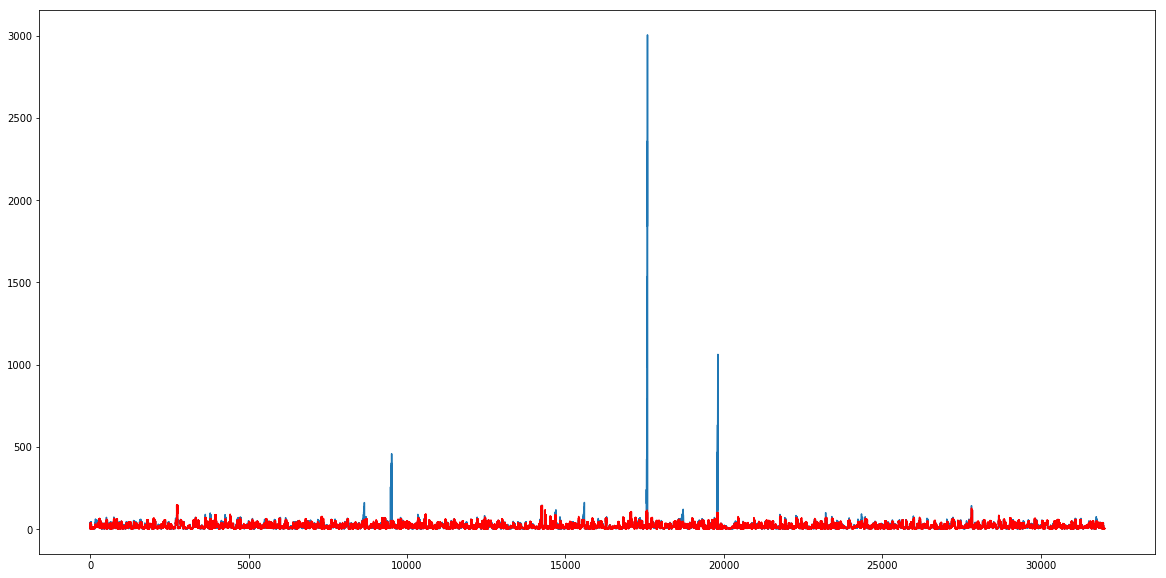

In [74]:
plt.figure(figsize=(20, 10))
plt.plot(sub.visitors)
plt.plot(other_sub.visitors, 'r')

In [75]:
sub['visit_date'] = sub.visit_date.astype('str')
def trn2test(tes_in_trn):
    tes_in_trn['id'] = tes_in_trn[['air_store_id', 'visit_date']].apply(
        lambda x: '_'.join(x), axis=1)
    return tes_in_trn[["id", 'visitors']]
sub_trans = trn2test(sub)

In [76]:
sub_trans.loc[sub_trans.visitors>120, 'visitors'] = 120

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


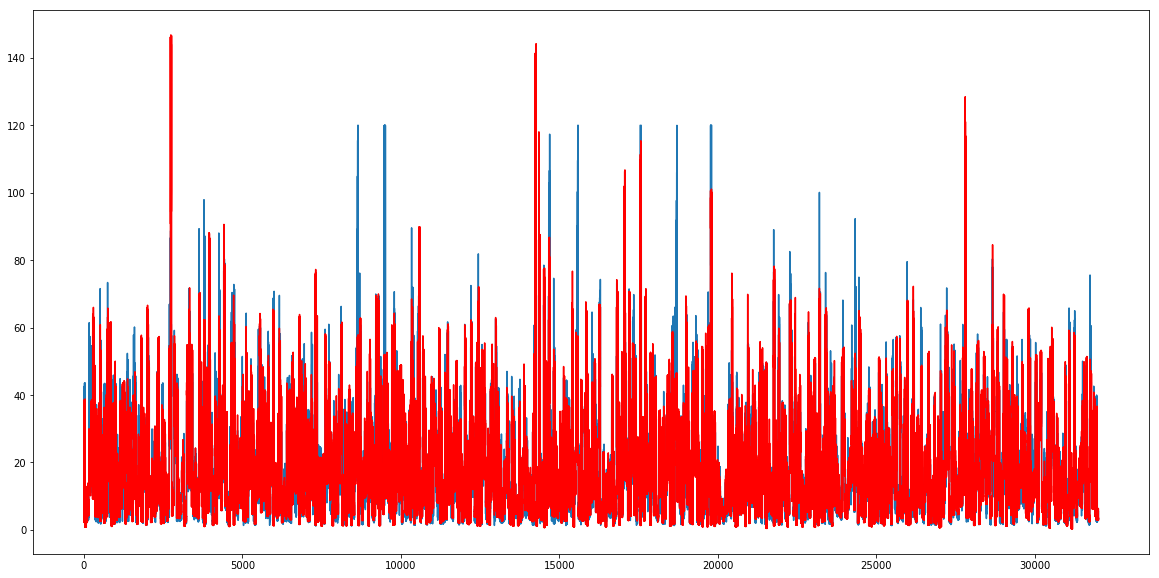

In [77]:
plt.figure(figsize=(20, 10))
plt.plot(sub_trans.visitors)
plt.plot(other_sub.visitors, 'r')

In [78]:
sub_trans.to_csv('./result/dl_pp_sub_160u_2.csv', index=False)

## RF

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [34]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [35]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.90154340623732288,
 0.63026306498518181,
 0.57855089284022332,
 0.49391001126525325)